# info

This script takes as input a internal standards-normalized XCMS file.

The tasks are:
- cell number correction.
- quantile normalization across all samples to address batch effects.
- quantile normalization across patient
- dose-response inference based on patient-specific fold-changes.
    
Then the output should be a list of m/z features for manual annotation along with figures for manuscript.

In [1]:
import pandas, numpy, seaborn, umap, collections

import sklearn, sklearn.decomposition, sklearn.preprocessing, sklearn.manifold, sklearn.cluster
import scipy, scipy.stats
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(12, 8)})

# 0. user-defined variables

In [2]:
data_file = '/home/adrian/gd15/hi/research/huvec/data/untargetted/ROSA_ACID_NEG_UT_NOMISNORM_AllBatches_untransformed.xlsx'

In [3]:
patients = [1, 2, 3, 4, 5]
time_points = [4, 24]
treatments = [1, 10, 100]

# 1. read data

In [4]:
original_data = pandas.read_excel(data_file)
original_data.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,287.490913,468.605181,189.373225,576.720535,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,180.314261,538.342307,130.499826,603.217924,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,284.725250,346.699905,391.221386,430.336737,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,EC_Rosa_1_695,31,EGM,2,NaN,0,215.383340,632.252573,521.709396,334.036661,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,EC_Rosa_1_711,32,EGM,2,NaN,0,308.400509,461.052002,269.282993,759.247147,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [5]:
info = original_data.iloc[:, :6]
info.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME
0,EC_Rosa_1_659,4,EGM,1,480000.0,0
1,EC_Rosa_1_666,5,EGM,1,480000.0,0
2,EC_Rosa_1_668,3,EGM,1,480000.0,0
3,EC_Rosa_1_695,31,EGM,2,NaN,0
4,EC_Rosa_1_711,32,EGM,2,NaN,0


In [6]:
intensities = original_data.iloc[:, 6:]
intensities.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,287.490913,468.605181,189.373225,576.720535,321.251154,490.368895,6963.243332,1574.419726,205.341230,224.308740,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,180.314261,538.342307,130.499826,603.217924,474.653477,426.956672,3643.910179,1315.831068,154.358128,170.502985,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,284.725250,346.699905,391.221386,430.336737,513.463286,895.284301,4228.235643,1443.006843,212.677132,391.189120,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,215.383340,632.252573,521.709396,334.036661,463.543369,871.905092,5835.753747,1678.712440,512.057985,1568.892520,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,308.400509,461.052002,269.282993,759.247147,568.430834,580.175396,1893.502277,1910.773244,312.684534,710.027443,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [7]:
peak_names = original_data.columns.to_list()[6:]
print(len(peak_names))
peak_names[:10]

1230


['X59.01097',
 'X61.017890000000001',
 'X67.016220000000004',
 'X74.021450000000002',
 'X77.052040000000005',
 'X77.052049999999994',
 'X78.956580000000002',
 'X78.956770000000006',
 'X79.955420000000004',
 'X80.962869999999995']

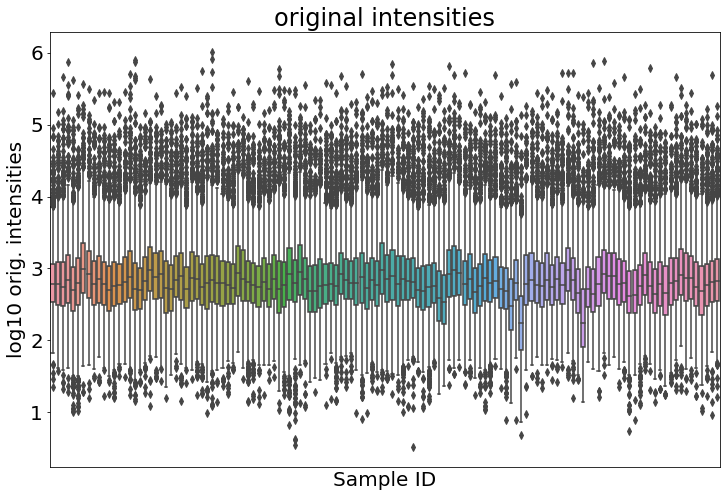

In [8]:
plotting_data = intensities.transpose()

g = seaborn.boxplot(data=numpy.log10(plotting_data))
g.set(xticks=[], ylabel='log10 orig. intensities', xlabel='Sample ID', title='original intensities')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

# 2. normalize intensities by cell numbers

In [9]:
intensities_by_cell = intensities.div(original_data['Cell  number']/1e6, axis=0)
intensities_by_cell.head(10)

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,598.939402,976.260794,394.527553,1201.501115,669.273238,1021.601865,14506.756942,3280.041095,427.794229,467.309876,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,375.654710,1121.546473,271.874638,1256.704008,988.861411,889.493067,7591.479539,2741.314726,321.579434,355.214552,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,593.177604,722.291469,815.044553,896.534868,1069.715180,1865.175628,8808.824257,3006.264256,443.077358,814.977334,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,621.152501,1825.424702,467.294062,2333.133711,1907.808060,2790.453418,23646.966493,8010.429693,660.939824,654.341910,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692


In [10]:
normalized_met_by_cell = pandas.concat([info, intensities_by_cell.reindex(info.index)], axis=1)
normalized_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,EC_Rosa_1_695,31,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EC_Rosa_1_711,32,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. remove conditions without cell numbers

In [11]:
# remove conditions for which cell numbers are not available
print('conditions before filtering {}'.format(normalized_met_by_cell.shape[0]))
finite_normalized_met_by_cell = normalized_met_by_cell[numpy.isfinite(normalized_met_by_cell['Cell  number']) == True]
print('conditions after filtering {}'.format(finite_normalized_met_by_cell.shape[0]))

finite_normalized_met_by_cell.head()

conditions before filtering 130
conditions after filtering 121


,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,621.152501,1825.424702,467.294062,2333.133711,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,761.738204,1880.681355,346.274473,2111.788781,...,1861.632957,2131.258746,1706.691679,2467.284050,1637.665077,8454.690040,10424.083896,11610.791792,10437.888669,9955.916753


# 4. bring it all to log10 scale

In [12]:
info = finite_normalized_met_by_cell.iloc[:, :6]
data = finite_normalized_met_by_cell.iloc[:, 6:]
transformed = data.apply(numpy.log10)
log10_finite_normalize_met_by_cell = pandas.concat([info, transformed.reindex(info.index)], axis=1)
log10_finite_normalize_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,2.777383,2.989566,2.596077,3.079724,...,2.987039,3.050040,2.967344,3.024066,2.819465,3.550368,3.685031,3.804287,3.676317,3.687104
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,2.574789,3.049817,2.434369,3.099233,...,3.173476,3.172003,3.033739,3.196783,2.410505,3.686390,3.847990,3.716066,3.852966,3.866767
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,2.773185,2.858712,2.911181,2.952567,...,2.952375,2.992246,2.888343,3.064598,2.334000,3.595451,3.547835,3.587492,3.563889,3.558928
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,2.793198,3.261364,2.669590,3.367940,...,3.431056,3.460569,3.363331,3.368212,3.308361,3.956101,4.043683,4.091079,4.088871,4.033026
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,2.881806,3.274315,2.539420,3.324650,...,3.269894,3.328636,3.232155,3.392219,3.214225,3.927098,4.018038,4.064862,4.018613,3.998081


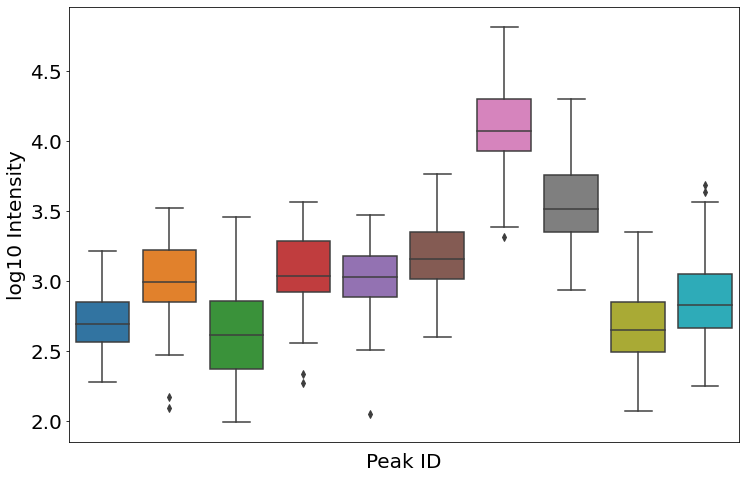

In [13]:
g = seaborn.boxplot(data=log10_finite_normalize_met_by_cell[peak_names[:10]], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(ylabel='log10 Intensity', xlabel='Peak ID')
matplotlib.pyplot.show()

# 5. perform quantile normalization across samples to address batch effect

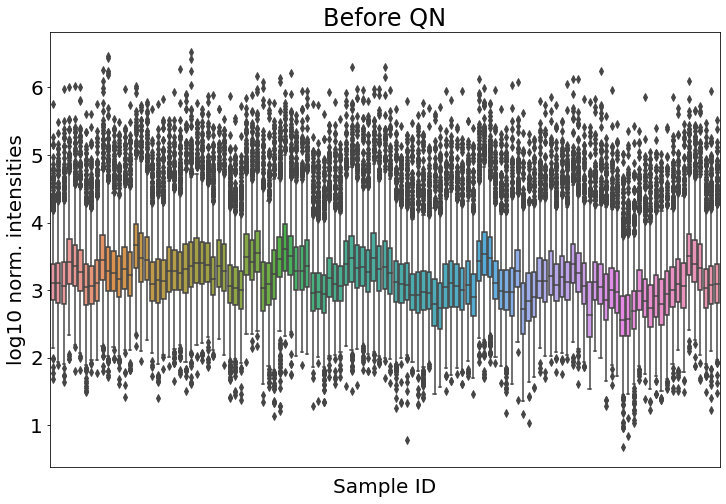

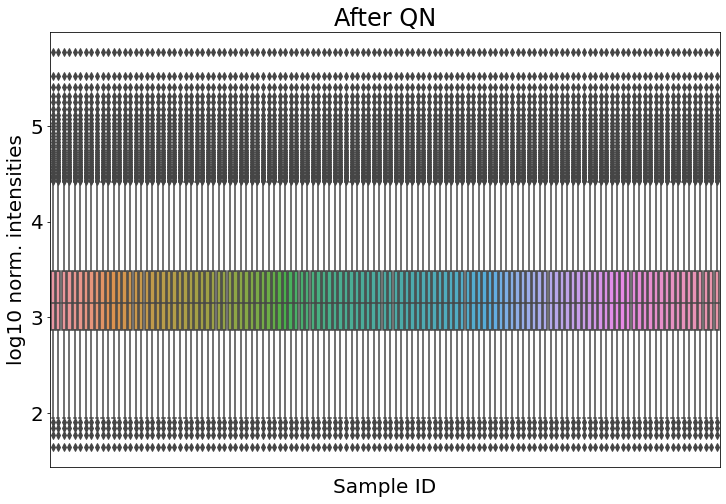

,Sample ID,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,EGM,0,1,2.794334,3.019640,2.627142,3.123284,2.840778,3.044494,...,3.014906,3.091518,2.990505,3.060599,2.835696,3.628641,3.750368,3.891556,3.745615,3.755109
1,EC_Rosa_1_666,EGM,0,1,2.607654,3.104925,2.412584,3.150455,3.051611,3.014100,...,3.233955,3.229593,3.083298,3.252518,2.398358,3.791086,3.932381,3.828591,3.944024,3.952900
2,EC_Rosa_1_668,EGM,0,1,2.837759,2.920775,2.981377,3.026136,3.121434,3.336177,...,3.025199,3.090544,2.948674,3.153500,2.334037,3.675726,3.622862,3.668984,3.644870,3.634795
9,EC_Rosa_1_787,EGM,0,4,2.534132,3.014100,2.353734,3.096735,3.034113,3.186189,...,3.167661,3.202538,3.094173,3.097649,3.057770,3.725911,3.799645,3.850255,3.847260,3.779479
10,EC_Rosa_1_805,EGM,0,4,2.642333,3.061422,2.228784,3.109595,3.047184,3.118578,...,3.055130,3.114162,3.026833,3.195821,3.005070,3.757501,3.834827,3.884510,3.837620,3.813846


In [14]:
###
### plot intensities before QN
###
tdf = log10_finite_normalize_met_by_cell.transpose()
tdf.drop(['Unnamed: 0', 'Number', 'Treatment', 'Batch', 'Cell  number', 'TIME'], axis=0, inplace=True)
tdf.head()

g = seaborn.boxplot(data=tdf)
g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='Before QN')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(tdf.values, axis=0), index=tdf.index, columns=tdf.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = tdf.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot intensities after QN
g = seaborn.boxplot(data=df_qn)
g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='After QN')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

###
### re-join
###
qn_peaks = df_qn.transpose()
qn_peaks.insert(0, 'Patient', log10_finite_normalize_met_by_cell['Batch'])
qn_peaks.insert(0, 'Time', log10_finite_normalize_met_by_cell['TIME']) 
qn_peaks.insert(0, 'Treatment', log10_finite_normalize_met_by_cell['Treatment']) 
qn_peaks.insert(0, 'Sample ID', log10_finite_normalize_met_by_cell['Unnamed: 0'])
qn_peaks.head()

# 6. explore patient variation

In [15]:
metabolite_peak = 'X147.02834999999999' 
metabolite_name = '2-hydroxy glutarate'
treatment = 10
timepoint =  4
metabolite_plotting_range = [2.4, 3.7]

In [16]:
sub = qn_peaks[(qn_peaks['Treatment'] == treatment) & (qn_peaks['Time'] == timepoint)]
sub.head(20)

,Sample ID,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
26,EC_Rosa_1_670,10,4,1,2.630583,3.058712,2.560540,3.115760,3.129682,3.146662,...,2.937727,3.015905,2.956773,3.245766,2.111426,3.677732,3.796821,3.837620,3.638206,3.810629
27,EC_Rosa_1_674,10,4,1,2.607654,2.994075,2.996840,3.087798,3.008652,3.135082,...,3.455777,3.372637,3.296673,3.235988,2.302421,3.686737,3.606541,3.684199,3.662340,3.689269
28,EC_Rosa_1_682,10,4,1,2.795501,3.127882,2.398358,3.158241,2.997638,3.108769,...,3.154365,3.217423,3.182565,3.237817,1.642718,3.710095,3.884510,3.948198,3.991180,3.910594
29,EC_Rosa_1_700,10,4,2,2.768072,3.116731,2.371112,3.113217,2.975997,3.200687,...,2.713603,2.757044,2.628826,3.136962,1.948743,3.651557,3.796821,3.940286,3.804659,3.807158
30,EC_Rosa_1_709,10,4,2,2.754780,3.019640,2.788863,3.111311,3.075186,2.984080,...,3.212165,3.217423,3.086027,3.086868,1.642718,3.539764,3.622862,3.710095,3.664544,3.634795
31,EC_Rosa_1_727,10,4,2,2.709498,3.066949,2.609714,3.103023,2.947565,2.668454,...,2.981377,3.042509,2.933154,3.174731,1.901832,3.583301,3.725911,3.518635,3.770771,3.762493
32,EC_Rosa_1_746,10,4,3,2.500772,3.072490,3.040783,3.127882,3.001388,3.182565,...,3.250449,3.299803,3.196791,3.287201,2.702025,3.765691,3.928514,3.731072,3.921495,3.914121
33,EC_Rosa_1_771,10,4,3,2.584007,3.134278,2.785592,3.123284,3.101953,3.375063,...,3.169673,3.138875,3.234931,3.126962,2.943322,3.725911,3.906924,3.903055,3.860339,3.463381
34,EC_Rosa_1_772,10,4,3,2.700539,2.963973,2.376526,3.000470,3.015905,3.138875,...,2.996840,3.011424,2.873993,3.273858,2.866827,3.723443,3.870237,3.932381,3.906924,3.917778
35,EC_Rosa_1_788,10,4,4,2.691906,3.040783,2.161374,3.142628,3.048153,3.039887,...,2.860729,2.988829,2.905200,3.055130,2.540145,3.695648,3.822793,3.810629,3.791086,3.723443


In [17]:
df = pandas.DataFrame()
for patient in patients:
  tag = 'Patient {}'.format(patient)
  values = sub[sub['Patient'] == patient][metabolite_peak].values  
  local = pandas.DataFrame({tag:values})
  df = pandas.concat((df, local), axis=1)
df.head()

,Patient 1,Patient 2,Patient 3,Patient 4,Patient 5
0,3.174731,3.572627,2.739381,2.942496,3.110446
1,2.951434,3.628641,2.619606,2.720156,3.058712
2,2.873058,3.277820,2.878672,2.477066,3.352061


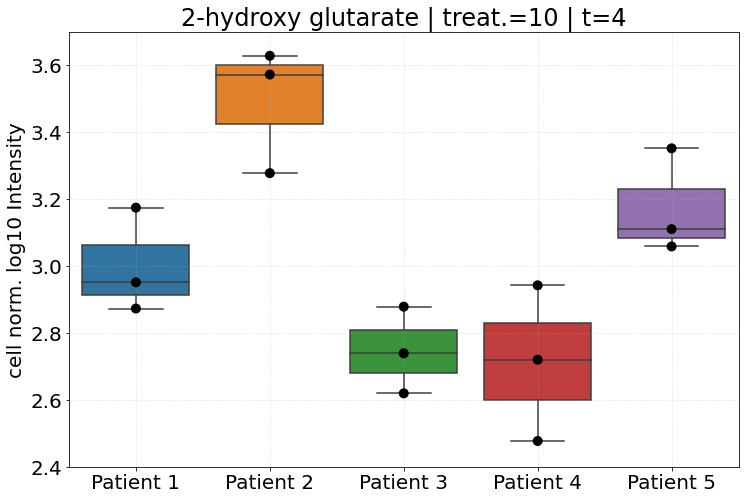

In [18]:
seaborn.boxplot(data=df)
g = seaborn.swarmplot(data=df, color='black', size=10)
g.set(ylabel='cell norm. log10 Intensity', title='{} | treat.={} | t={}'.format(metabolite_name, treatment, timepoint), ylim=metabolite_plotting_range)
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.show()

In [19]:
#
# define function for quantile normalization at patient variation level
#

def quantile_normalization(df):

  "Quantile normalization consists on sorting, averaging and re-ordering."
  "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
  ### check that each batch measurement is unique. If all batch measurements are the same, add noise
  noise = 0.01
  for label, values in df.iteritems():
    if len(values.unique()) == 1:
      v = values.unique()[0]
      df[label] = [v-noise, v, v+noise]

  # step 1/3: sorting sample values
  df_sorted = pandas.DataFrame(numpy.sort(df.values, axis=0), index=df.index, columns=df.columns)
  # step 2/3: averaging rank values across samples
  df_mean = df_sorted.mean(axis=1)
  df_mean.index = numpy.arange(1, len(df_mean) + 1)
  # step 3/3: re-ordering samples
  df.rank(method="min").astype(int)
  df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

  ### two extra steps, outside of quantile normalization
  
  # (1/2) use df_qn as reference to map original values, so they can be merged later
  target_means = df_qn.mean(axis=0)
  target_sds = df_qn.std(axis=0)

  original_means = df.mean(axis=0)
  original_sds = df.std(axis=0)
  df_scaled = df.subtract(original_means, axis=1).div(original_sds, axis=1)

  df_target = df_scaled.mul(target_sds, axis=1).add(target_means, axis=1)

  # (2/2) join values as one single column
  joined_values = df_target.values.flatten()
  if sum(numpy.isnan(joined_values)) > 0:
    raise ValueError('found nan values after QN')

  ### case-specific convenience function to quantify batch shift
  bs = (df.mean(axis=0) - df_qn.mean(axis=0)) / df_qn.mean(axis=0)
  batch_shift = pandas.DataFrame(bs).transpose()

  return df_qn, df_target, joined_values, batch_shift

In [20]:
df_qn, df_target, joined_values, batch_shift = quantile_normalization(df)

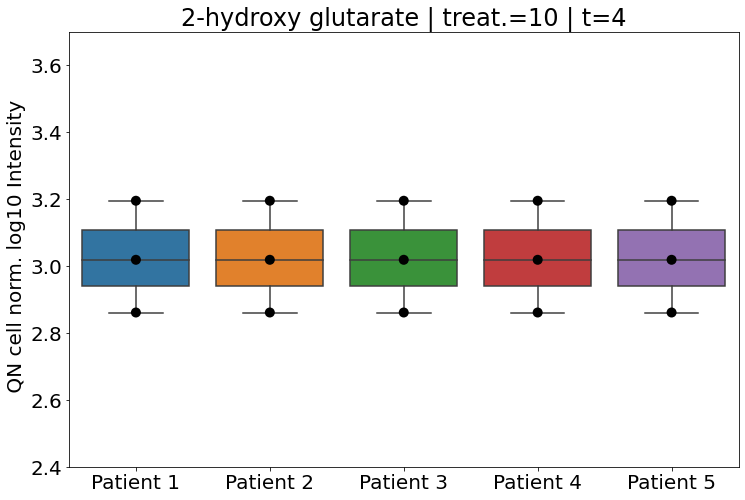

In [21]:
seaborn.boxplot(data=df_qn)
g = seaborn.swarmplot(data=df_qn, color='black', size=10)
g.set(ylabel=' QN cell norm. log10 Intensity', title='{} | treat.={} | t={}'.format(metabolite_name, treatment, timepoint), ylim=metabolite_plotting_range)
matplotlib.pyplot.show()

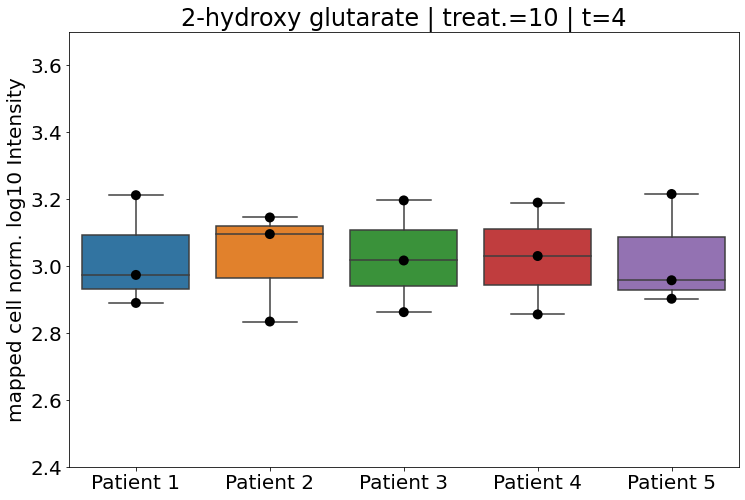

In [22]:
seaborn.boxplot(data=df_target)
g = seaborn.swarmplot(data=df_target, color='black', size=10)
g.set(ylabel='mapped cell norm. log10 Intensity', title='{} | treat.={} | t={}'.format(metabolite_name, treatment, timepoint), ylim=metabolite_plotting_range)
matplotlib.pyplot.show()

Comparison to previous normalization

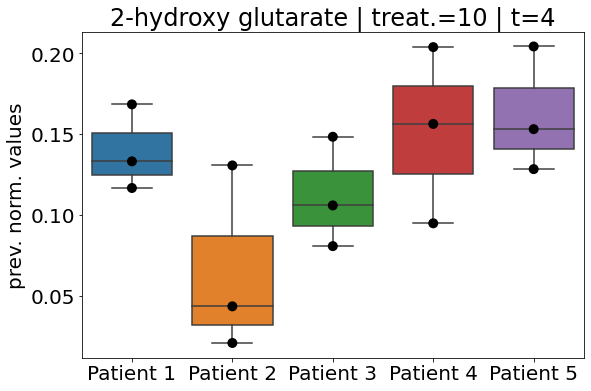

In [23]:
previous_file = '/home/adrian/gd15/hi/research/huvec/data/untargetted/AllBatchdata_BatchNorm.xlsx'
previous_data = pandas.read_excel(previous_file)

previous_sub = previous_data[(previous_data['Treatment'] == treatment) & (previous_data['TIME'] == timepoint)]

df = pandas.DataFrame()
for patient in patients:
  tag = 'Patient {}'.format(patient)
  values = previous_sub[previous_sub['Batch'] == patient][metabolite_peak].values
  if len(values) == 2:
    values = numpy.insert(values, 0, numpy.mean(values))
  local = pandas.DataFrame({tag:values})
  df = pandas.concat((df, local), axis=1)

matplotlib.pyplot.figure(figsize=(9, 6))
seaborn.boxplot(data=df)
g = seaborn.swarmplot(data=df, color='black', size=10)
g.set(ylabel='prev. norm. values', title='{} | treat.={} | t={}'.format(metabolite_name, treatment, timepoint))
matplotlib.pyplot.show()

# 7. correct for patient variability

In [24]:
# working variable should be qn_peaks
qn_peaks.head()

,Sample ID,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,EGM,0,1,2.794334,3.019640,2.627142,3.123284,2.840778,3.044494,...,3.014906,3.091518,2.990505,3.060599,2.835696,3.628641,3.750368,3.891556,3.745615,3.755109
1,EC_Rosa_1_666,EGM,0,1,2.607654,3.104925,2.412584,3.150455,3.051611,3.014100,...,3.233955,3.229593,3.083298,3.252518,2.398358,3.791086,3.932381,3.828591,3.944024,3.952900
2,EC_Rosa_1_668,EGM,0,1,2.837759,2.920775,2.981377,3.026136,3.121434,3.336177,...,3.025199,3.090544,2.948674,3.153500,2.334037,3.675726,3.622862,3.668984,3.644870,3.634795
9,EC_Rosa_1_787,EGM,0,4,2.534132,3.014100,2.353734,3.096735,3.034113,3.186189,...,3.167661,3.202538,3.094173,3.097649,3.057770,3.725911,3.799645,3.850255,3.847260,3.779479
10,EC_Rosa_1_805,EGM,0,4,2.642333,3.061422,2.228784,3.109595,3.047184,3.118578,...,3.055130,3.114162,3.026833,3.195821,3.005070,3.757501,3.834827,3.884510,3.837620,3.813846


In [25]:
treatments = ['EGM', 1, 10, 100]
timepoints = [0, 4, 24]

conditions = [('EGM', 0), ('EGM', 4), ('EGM', 24)]
for treatment in treatments[1:]:
    for timepoint in timepoints[1:]:
        condition = (treatment, timepoint)
        conditions.append(condition)
print(conditions)

[('EGM', 0), ('EGM', 4), ('EGM', 24), (1, 4), (1, 24), (10, 4), (10, 24), (100, 4), (100, 24)]


In [26]:
%%time

all_columns = ['Treatment', 'Time', 'Replicate'] + peak_names
peaks_ic = pandas.DataFrame(columns=all_columns)
batch_shift_ic = pandas.DataFrame(columns=['Patient ' + str(patient) for patient in patients])

for condition in conditions:
  treatment = condition[0]; timepoint = condition[1]
  container = {}
  for peak_name in peak_names:

    # (1/2) retrieve specific data
    sub = qn_peaks[(qn_peaks['Treatment'] == treatment) & (qn_peaks['Time'] == timepoint)]

    before_values = {}
    for patient in patients:
      values = sub[sub['Patient'] == patient][peak_name].values
      # impute an average value in case of two values (Patient 5)
      if len(values) == 2:
        #print('imputing...')
        values = numpy.insert(values, 0, numpy.mean(values))
      if len(values) > 0:
        before_values['Patient {}'.format(patient)] = values

    df = pandas.DataFrame(before_values)

    # (2/2) quantile normalization
    df_qn, df_target, joined_values, batch_shift = quantile_normalization(df)

    # (3/3) store information as needed
    container[peak_name] = joined_values

    batch_shift_ic = pandas.concat([batch_shift_ic, batch_shift], axis=0)
  
  # final storage
  for i in range(len(joined_values)):
    local_container = {'Replicate':i, 'Treatment':treatment, 'Time':timepoint}
    for peak_name in container:
      local_container[peak_name] = container[peak_name][i]
    peaks_ic = peaks_ic.append(local_container, ignore_index=True)  

CPU times: user 1min 11s, sys: 0 ns, total: 1min 11s
Wall time: 1min 11s


In [27]:
peaks_ic.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0,0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0,1,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0,2,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0,3,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0,4,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [28]:
peaks_ic.tail()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
118,100.0,24.0,7.0,2.779846,3.172528,2.963769,3.251544,2.761526,3.189147,3.857269,...,2.588433,2.790295,2.704459,3.055224,2.654439,3.312947,3.594402,3.602590,3.522195,3.542725
119,100.0,24.0,8.0,2.724025,3.133532,2.647625,3.245464,3.240781,3.462044,4.146592,...,2.828934,2.951793,3.020111,3.267789,2.152626,3.748962,3.874495,3.837302,3.871287,3.820243
120,100.0,24.0,9.0,2.682043,3.035865,2.960725,3.047795,2.949646,3.273423,4.064389,...,2.884726,2.955181,2.822045,3.137322,2.050516,3.608898,3.770203,3.810570,3.823127,3.706630
121,100.0,24.0,10.0,2.788015,3.051387,2.434155,3.047309,2.829969,3.312372,4.180174,...,2.600986,2.790380,2.908164,3.105119,2.813513,3.552164,3.741591,3.809609,3.746415,3.739735
122,100.0,24.0,11.0,2.615944,2.868514,2.503521,2.948165,3.041068,3.020996,4.136712,...,2.950874,3.006080,2.912122,3.051190,2.604046,3.630214,3.659103,3.695250,3.842232,3.624031


In [29]:
batch_shift_ic.head()
print(batch_shift_ic.shape)

(11070, 5)


In [30]:
11070/len(peak_names)

9.0

# 8. visualize patient variability

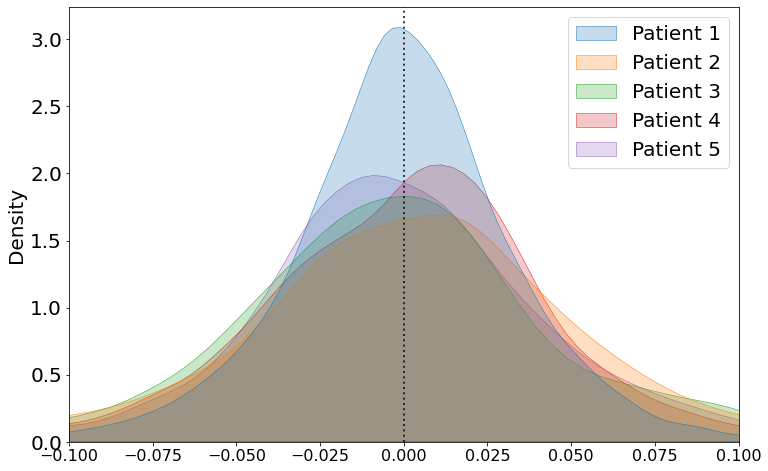

In [31]:
g = seaborn.kdeplot(data=batch_shift_ic, fill=True, palette="tab10", alpha=1/4, linewidth=1/2)
g.set(xlim=(-0.1, 0.1))
matplotlib.pyplot.axvline(x=0, lw=2, alpha=3/4, color='black', ls=':')
matplotlib.pyplot.xticks(fontsize=16)
matplotlib.pyplot.show()

# 9. visualize working data

In [32]:
peaks_ic.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0,0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0,1,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0,2,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0,3,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0,4,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [33]:
tdf = peaks_ic.transpose()
tdf.drop(['Treatment', 'Time', 'Replicate'], axis=0, inplace=True)
tdf.head()

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
X59.01097,2.73119,2.57706,2.567796,2.700993,2.769198,2.790132,2.670344,2.573629,2.645118,2.639258,...,2.614856,2.813361,2.637466,2.668974,2.80628,2.779846,2.724025,2.682043,2.788015,2.615944
X61.017890000000001,3.039996,2.966918,3.102377,3.041685,2.967684,3.101454,2.88533,3.077158,3.011934,3.029698,...,3.123861,2.95879,3.037993,3.134983,2.824585,3.172528,3.133532,3.035865,3.051387,2.868514
X67.016220000000004,2.4989,2.478636,2.315301,2.328574,2.802023,2.809014,2.450649,2.850545,2.442308,2.719448,...,2.899467,2.624626,2.956811,2.495765,2.758295,2.963769,2.647625,2.960725,2.434155,2.503521
X74.021450000000002,3.146793,3.080018,3.174088,3.091159,3.049199,3.198903,3.049448,3.125811,3.080211,3.114673,...,3.277092,3.114702,3.125273,3.276995,2.99001,3.251544,3.245464,3.047795,3.047309,2.948165
X77.052040000000005,2.926058,2.975931,3.080577,2.99307,3.131748,3.169382,2.939389,3.056352,2.952228,2.9093,...,3.241788,3.18811,2.923422,2.807734,2.918947,2.761526,3.240781,2.949646,2.829969,3.041068


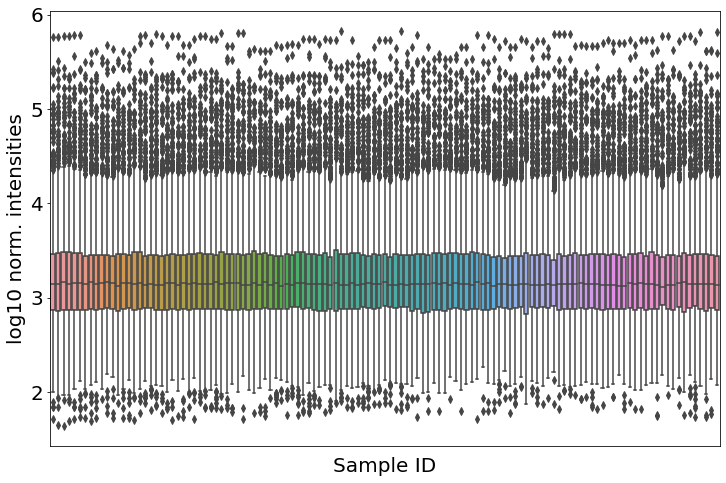

In [34]:
g = seaborn.boxplot(data=tdf)
g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

# 10. define dose responders

## 10.1. re-define some data

In [35]:
wdf = peaks_ic
wdf.tail()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
118,100.0,24.0,7.0,2.779846,3.172528,2.963769,3.251544,2.761526,3.189147,3.857269,...,2.588433,2.790295,2.704459,3.055224,2.654439,3.312947,3.594402,3.602590,3.522195,3.542725
119,100.0,24.0,8.0,2.724025,3.133532,2.647625,3.245464,3.240781,3.462044,4.146592,...,2.828934,2.951793,3.020111,3.267789,2.152626,3.748962,3.874495,3.837302,3.871287,3.820243
120,100.0,24.0,9.0,2.682043,3.035865,2.960725,3.047795,2.949646,3.273423,4.064389,...,2.884726,2.955181,2.822045,3.137322,2.050516,3.608898,3.770203,3.810570,3.823127,3.706630
121,100.0,24.0,10.0,2.788015,3.051387,2.434155,3.047309,2.829969,3.312372,4.180174,...,2.600986,2.790380,2.908164,3.105119,2.813513,3.552164,3.741591,3.809609,3.746415,3.739735
122,100.0,24.0,11.0,2.615944,2.868514,2.503521,2.948165,3.041068,3.020996,4.136712,...,2.950874,3.006080,2.912122,3.051190,2.604046,3.630214,3.659103,3.695250,3.842232,3.624031


In [36]:
treatments = ['EGM', 1, 10, 100]
timepoints = [0, 4, 24]

conditions = [('EGM', 0), ('EGM', 4), ('EGM', 24)]
for timepoint in timepoints[1:]:
  for treatment in treatments[1:]:
    condition = (treatment, timepoint)
    conditions.append(condition)
print(conditions, len(conditions))

condition_colors = ['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red']
condition_labels = ['c 0h', 'c 4h', 'c 24h', '0.5 4h', '5 4h', '50 4h', '0.5 24h', '5 24h', '50 24h']

print(condition_colors, len(condition_colors))

[('EGM', 0), ('EGM', 4), ('EGM', 24), (1, 4), (10, 4), (100, 4), (1, 24), (10, 24), (100, 24)] 9
['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red'] 9


## 10.2. read extra information

In [37]:
# read ottars annotation file
annotation_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/Annotations of Adrians hits.xlsx'
annotation = pandas.read_excel(annotation_file, usecols=['ottar calls', 'dose-responding mz', 'annotated mz'])
annotation.head()

,ottar calls,dose-responding mz,annotated mz
0,glutamate,146.0799,146.043687
1,N-acetyl-glutamate,102.0536,102.053623
2,N-acetyl-glutamate,144.0646,144.064567
3,pantothenic acid,218.1016,218.101624
4,cholesterol derivative,321.1625,321.209535


In [38]:
annotation['diff'] = numpy.abs(annotation['dose-responding mz'] - annotation['annotated mz'])
print(annotation.shape)
annotation = annotation[annotation['diff'] < 0.01]
print(annotation.shape)
#annotation.tail(50)

(121, 4)
(67, 4)


In [39]:
print(len(peak_names), peak_names[:10])

1230 ['X59.01097', 'X61.017890000000001', 'X67.016220000000004', 'X74.021450000000002', 'X77.052040000000005', 'X77.052049999999994', 'X78.956580000000002', 'X78.956770000000006', 'X79.955420000000004', 'X80.962869999999995']


## 10.3. spotcheck for adrenaline sulfate metabolite

In [40]:
target = 'epinephrine sulfate'
peak_mz = float(annotation[annotation['ottar calls'] == target]['dose-responding mz'])
peak_mz

262.0386

In [41]:
match = None
for column in wdf.columns[3:]:
  value = float(column[1:13])
  diff = numpy.abs(peak_mz - value)
  if diff < 1e-4:
    print(diff)
    match = column
print(match)

working_peak_mz = match

9.999951089412207e-09
X262.03859999999997


In [42]:
plotting_values = []

for condition in conditions:
  treatment = condition[0]; timepoint = condition[1]

  sub = wdf[(wdf['Treatment'] == treatment) & (wdf['Time'] == timepoint)][working_peak_mz]
  box = sub.values
  plotting_values.append(box)

  print('treatment {}, timepoint {}, shape {}'.format(treatment, timepoint, sub.shape))

treatment EGM, timepoint 0, shape (6,)
treatment EGM, timepoint 4, shape (15,)
treatment EGM, timepoint 24, shape (15,)
treatment 1, timepoint 4, shape (15,)
treatment 10, timepoint 4, shape (15,)
treatment 100, timepoint 4, shape (15,)
treatment 1, timepoint 24, shape (15,)
treatment 10, timepoint 24, shape (15,)
treatment 100, timepoint 24, shape (12,)


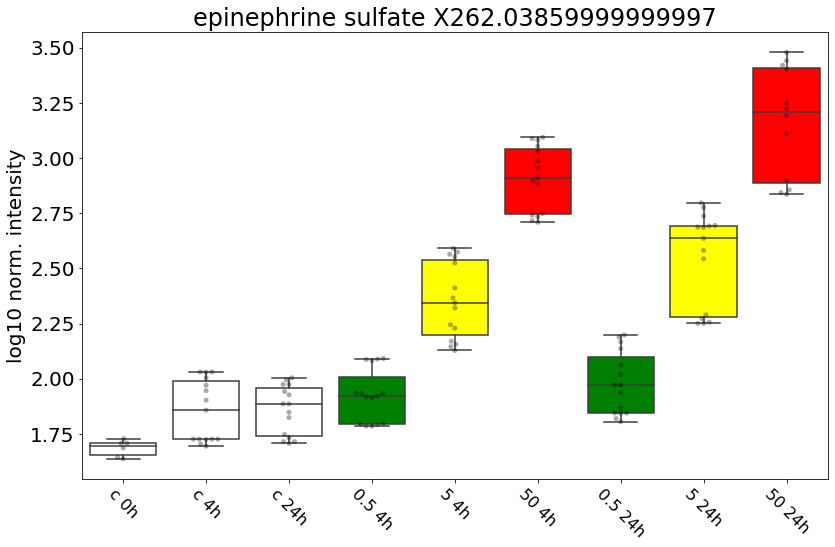

<Figure size 864x576 with 0 Axes>

In [43]:
g = seaborn.boxplot(data=plotting_values)
h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3)

g.set(ylabel='log10 norm. intensity', title='{} {}'.format(target, working_peak_mz))
for i in range(len(g.artists)):
    g.artists[i].set_facecolor(condition_colors[i])
matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
matplotlib.pyplot.clf()

## 10.4. visualization of samples

In [44]:
wdf.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0,0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0,1,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0,2,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0,3,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0,4,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [45]:
# Separating out the features
x = wdf.loc[:, peak_names].values

sub4 = wdf[wdf['Time'] == 4]
x4 = sub4.loc[:, peak_names].values

sub24 = wdf[wdf['Time'] == 24]
x24 = sub24.loc[:, peak_names].values

print(x[:3])

[[2.73119002 3.03999643 2.49889979 ... 3.90286354 3.79841371 3.77929788]
 [2.57705968 2.96691755 2.47863587 ... 3.76717719 3.78446988 3.69233337]
 [2.56779611 3.10237684 2.31530088 ... 3.86187114 3.91361893 3.89281611]]


In [46]:
# Standardizing the features
x = sklearn.preprocessing.StandardScaler().fit_transform(x)
x4 = sklearn.preprocessing.StandardScaler().fit_transform(x4)
x24 = sklearn.preprocessing.StandardScaler().fit_transform(x24)
x[:3]

array([[ 0.47671593,  0.3518314 , -0.61884887, ...,  1.46534957,
         0.50069521,  0.54273793],
       [-1.17237781, -0.45311811, -0.72210196, ...,  0.00453192,
         0.35610128, -0.32833978],
       [-1.27149199,  1.03893931, -1.5543615 , ...,  1.02401982,
         1.69534362,  1.67979031]])

### 10.4.1. PCA for all samples

In [47]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(123, 2)


,PC1,PC2
0,3.693296,6.490991
1,-2.834521,-2.564043
2,-4.128782,-15.184256
3,-2.565231,-4.151067
4,11.313780,-5.972866


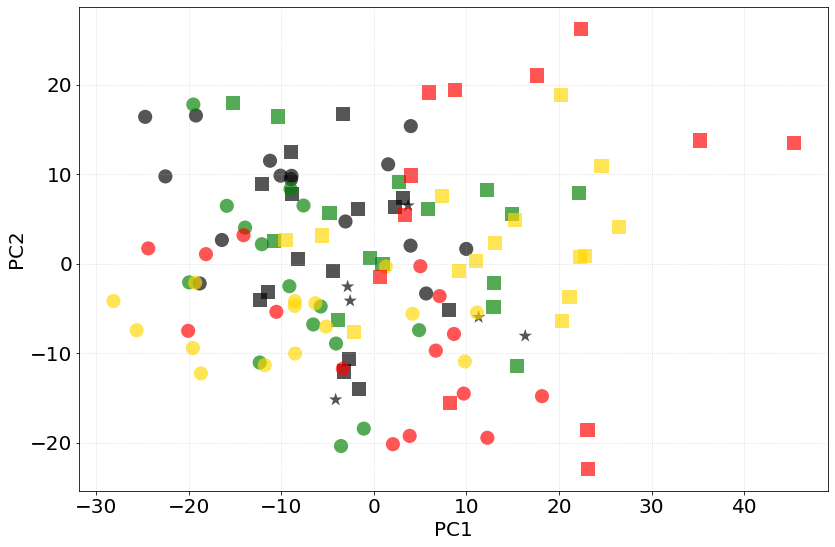

In [48]:
for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == 1:
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == 10:
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == 100:
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = principal_df.iloc[i]['PC1']
  posy = principal_df.iloc[i]['PC2']

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

### 10.4.2. tSNE for all samples

In [49]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='cosine', early_exaggeration=3, method='exact').fit_transform(x)

/home/adrian/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/adrian/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 123 / 123
[t-SNE] Mean sigma: 0.260131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 7.654380
[t-SNE] KL divergence after 1000 iterations: 0.521119


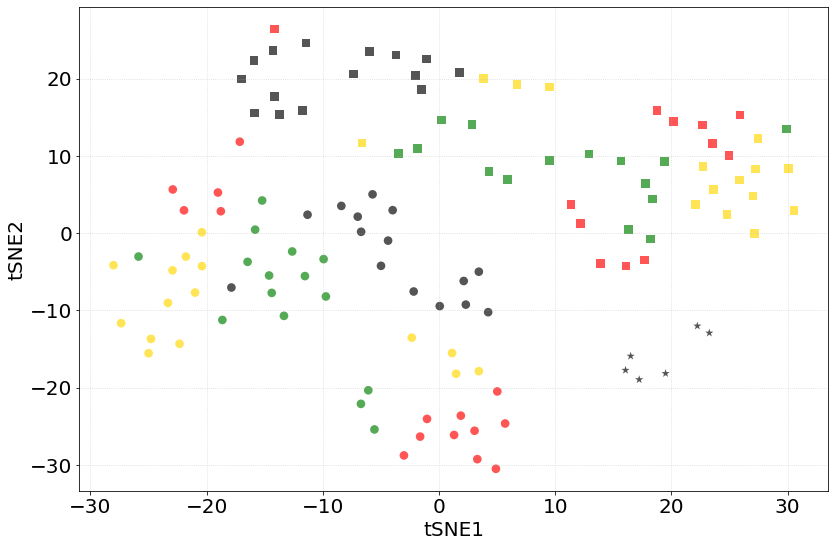

In [50]:
for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == 1.0:
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == 10.0:
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == 100.0:
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = embedding[i][0]
  posy = embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 10.4.3. UMAP for all samples

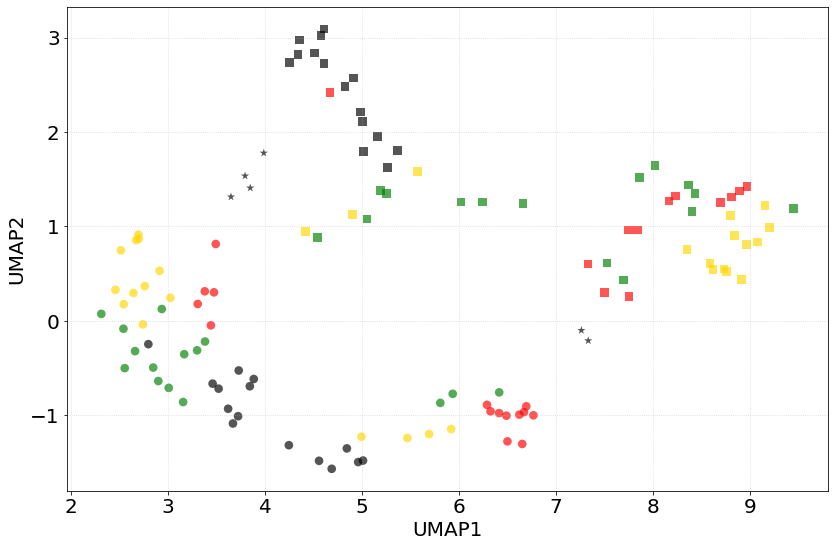

In [51]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0)
umap_embedding = reducer.fit_transform(x)

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == 1.0:
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == 10.0:
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == 100.0:
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 10.4.4. visualization for 4 h

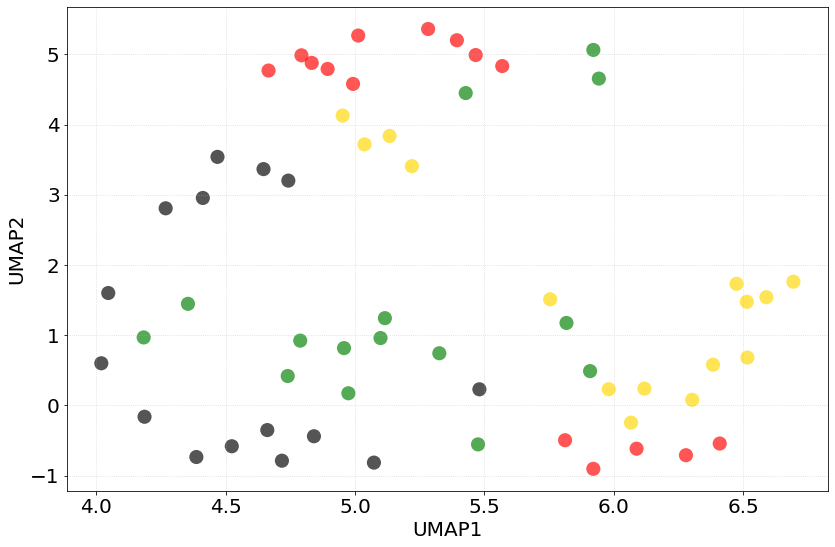

In [52]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=0)
umap_embedding = reducer.fit_transform(x4)

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == 1:
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == 10:
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == 100:
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

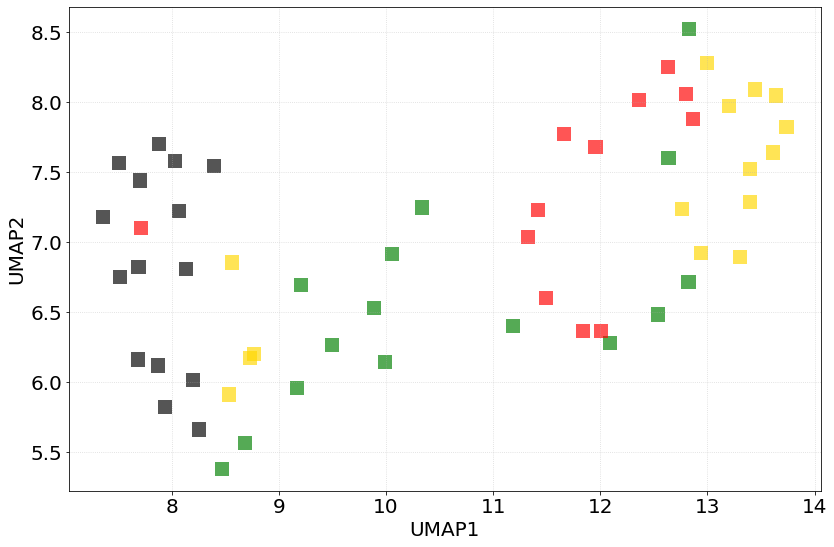

In [53]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=1)
umap_embedding = reducer.fit_transform(x24)

for i in range(len(sub24.index)):

  # colors
  if sub24.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub24.iloc[i]['Treatment'] == 1:
    plotting_color = 'green'
  elif sub24.iloc[i]['Treatment'] == 10:
    plotting_color = 'gold'
  elif sub24.iloc[i]['Treatment'] == 100:
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub24.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub24.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub24.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 10.5. determine dose responders

In [54]:
print(wdf.shape)
wdf.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0,0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0,1,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0,2,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0,3,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0,4,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [55]:
delta_threshold = numpy.log10(2)
p_value_threshold = 0.05
correlations_df = pandas.DataFrame(columns=['peak name', 'log2FC', 'P value', 'r value'])

working_times = [4, 24]
for wt in working_times:
  sub = wdf[wdf['Time'] == wt]
  print(sub.shape)

  distribution_of_fc = []
  for peak_name in peak_names:
    x = [] ; y = []
    for index, row in sub.iterrows():

      treatment = row['Treatment']
      if treatment == 'EGM':
        x.append(0)
      elif treatment == 1:
        x.append(1)
      elif treatment == 10:
        x.append(2)
      elif treatment == 100:
        x.append(3)
      else:
        raise ValueError('error')

      value = float(row[peak_name])
      y.append(value)
    
    # linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    ypred = slope*numpy.array(x) + intercept
    delta = numpy.abs(numpy.max(ypred) - numpy.min(ypred))
    log2FC = numpy.log2(10**delta)
    if r_value < 0:
      log2FC = -log2FC
    
    new_row = {'time':wt, 'peak name':peak_name, 'log2FC':log2FC, 'P value':p_value, 'r value':r_value}
    correlations_df = correlations_df.append(new_row, ignore_index=True)
    
    if (delta > delta_threshold) & (p_value < p_value_threshold):
      print(peak_name, delta, p_value, r_value)
  print()

correlations_df.head()

(60, 1233)
X92.925600000000003 0.39095394048784815 6.613829788621203e-05 0.4917046086428231
X133.98987 0.30805074768585694 0.000643753426015985 0.42813639123726455
X146.07991000000001 0.3172422882345898 3.9923421730868845e-05 -0.5042620087364151
X262.03859999999997 1.0787045642517978 2.2405680834192577e-23 0.9064180960735608
X276.05410000000001 1.1434030356201443 1.6597029625156344e-25 0.9215605121101373
X276.05387000000002 1.0307636426885978 1.5085898777319606e-25 0.9218284440821256
X306.07519000000002 0.37000501457442825 4.0591476404469054e-06 -0.5556327434976771
X328.05739999999997 0.35447622683381486 0.00013578237592335666 -0.472921147832539
X329.06038999999998 0.3142660249759617 5.16561692790371e-06 -0.5505963315417896
X360.08832000000001 0.3363583465386246 2.482280443695937e-06 -0.565659561321259

(57, 1233)
X96.919939999999997 0.3089047149782158 0.00016546637048530188 -0.47869363298226003
X175.02331000000001 0.8658486650765544 1.0507720169451485e-15 0.8321732941508257
X199.16800

,peak name,log2FC,P value,r value,time
0,X59.01097,0.160578,0.092914,0.218881,4.0
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0


In [56]:
correlations_df[correlations_df['peak name'] == 'X276.05387000000002']

,peak name,log2FC,P value,r value,time
394,X276.05387000000002,3.424123,1.508590e-25,0.921828,4.0
1624,X276.05387000000002,4.607447,5.899145e-25,0.926148,24.0


In [57]:
# add BH correction
all_p_values = correlations_df['P value'].to_list()
storage = statsmodels.stats.multitest.multipletests(all_p_values, alpha=0.1, method='fdr_bh')
corrected = storage[1]
correlations_df['corrected P value'] = corrected
correlations_df

,peak name,log2FC,P value,r value,time,corrected P value
0,X59.01097,0.160578,0.092914,0.218881,4.0,0.195190
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0,0.127425
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0,0.733935
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0,0.005115
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0,0.029566
...,...,...,...,...,...,...
2455,X996.78913999999997,-0.155759,0.292379,-0.141899,24.0,0.433808
2456,X996.80704000000003,-0.162769,0.233404,-0.160365,24.0,0.368296
2457,X996.82538,-0.207772,0.076811,-0.236279,24.0,0.171778
2458,X996.84303,-0.108669,0.376501,-0.119361,24.0,0.513695


In [58]:
mean = numpy.mean(correlations_df['log2FC'])
std = numpy.std(correlations_df['log2FC'])
threshold = mean + 1.959964*std
print(threshold)

dose_t = correlations_df[(numpy.abs(correlations_df['log2FC']) > threshold) & (correlations_df['corrected P value'] < 0.05)]

print(threshold)
print(dose_t.shape)
dose_t.head()

0.8314568965620485
0.8314568965620485
(63, 6)


,peak name,log2FC,P value,r value,time,corrected P value
29,X92.925600000000003,1.298721,6.613830e-05,0.491705,4.0,0.001139
31,X94.922759999999997,0.895814,9.782844e-03,0.331020,4.0,0.038382
33,X96.965789999999998,0.988130,8.079288e-03,0.338896,4.0,0.033180
37,X97.009529999999998,-0.980578,3.961084e-03,-0.366632,4.0,0.020398
41,X102.05362,-0.926010,2.800367e-07,-0.606523,4.0,0.000025


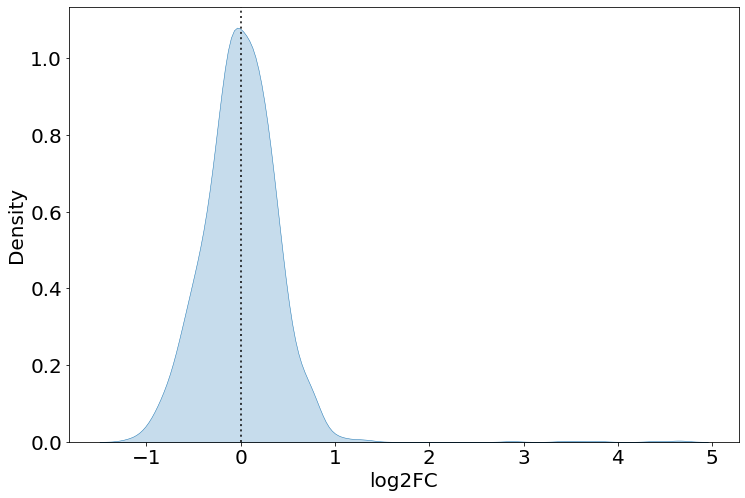

In [59]:
# histogram of log2FC
g = seaborn.kdeplot(data=correlations_df['log2FC'], fill=True, palette="tab10", alpha=1/4, linewidth=1/2)
matplotlib.pyplot.axvline(x=0, lw=2, alpha=3/4, color='black', ls=':')
matplotlib.pyplot.show()

## 10.6. generate heatmap

In [60]:
relevant_peaks = list(set(dose_t['peak name'].to_list()))
print(relevant_peaks[:5], len(relevant_peaks))

['X218.10158000000001', 'X321.17340000000002', 'X797.51549', 'X262.03859999999997', 'X166.08246'] 60


In [61]:
references = [(4, 'EGM'), (24, 'EGM')]
conditions = [1, 10, 100]
pdf = pandas.DataFrame()

for peak_name in relevant_peaks:
  heatmap_values = []; all_boxplot_values = []
  for reference in references:
    for condition in conditions:

      denominator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == reference[1])][peak_name].values
      numerator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == condition)][peak_name].values

      log10FC = numpy.mean(numerator_values) - numpy.mean(denominator_values)
      log2FC = numpy.log2(10**log10FC)
      heatmap_values.append(log2FC)

      boxplot_values = numpy.log2(10**(numerator_values - numpy.mean(denominator_values)))
      all_boxplot_values.append(boxplot_values)

  pdf = pandas.concat((pdf, pandas.DataFrame({peak_name:heatmap_values})), axis=1)

  # generate figure of boxplots
  g = seaborn.boxplot(data=all_boxplot_values)
  h = seaborn.swarmplot(data=all_boxplot_values, color='black', alpha=1/3)
  g.set(ylabel='log2 rel. intensity', title='{}'.format(peak_name))
  b_colors = ['tab:green', 'gold', 'tab:red', 'tab:green', 'gold', 'tab:red']
  for i in range(len(g.artists)):
    g.artists[i].set_facecolor(b_colors[i])
  matplotlib.pyplot.grid(':', alpha=0.5)
  matplotlib.pyplot.tight_layout()
  figure_path = '/home/adrian/gd15/hi/research/huvec/results/untargeted/figures/boxplots/{}.v2.svg'.format(peak_name) 
  matplotlib.pyplot.savefig(figure_path)
  matplotlib.pyplot.clf()

print(pdf.shape)
pdf.head()

(6, 60)


,X218.10158000000001,X321.17340000000002,X797.51549,X262.03859999999997,X166.08246,X736.13774000000001,X328.05739999999997,X500.92164000000002,X957.19478000000004,X560.60392999999999,...,X397.22516999999999,X133.98987,X329.06038999999998,X883.52017999999998,X272.08780000000002,X562.60356999999999,X279.16082999999998,X162.83770000000001,X276.05410000000001,X885.54012999999998
0,-0.752395,0.273868,-0.438642,0.233545,0.071142,0.491006,-0.294119,-0.450986,-0.241787,0.924272,...,0.328114,0.327894,-0.403244,-0.488324,-0.369125,0.578058,-0.326795,0.680312,0.133205,-0.493951
1,-0.602723,0.545262,-0.443705,1.665070,0.153239,-0.691675,-0.285462,-0.642441,-1.003259,0.841890,...,0.469377,0.120017,-0.409124,-0.734844,-0.337504,0.603364,0.799664,0.667558,1.961848,-0.897410
2,-1.003354,0.755746,-0.963922,3.504357,0.018522,0.225710,-1.311269,-0.281300,-0.845186,0.737056,...,0.406069,1.206317,-1.158006,-1.022351,-0.952965,0.496956,0.686503,0.561739,3.610788,-0.851332
3,-0.114541,0.243674,0.096125,0.398993,-0.261877,-0.226701,0.289119,0.466293,-0.666534,-0.335639,...,0.460085,0.318544,0.356946,-0.275388,0.342963,-0.196772,-0.624210,0.122664,0.816962,-0.394041
4,-0.345187,0.739899,-0.267424,2.274986,-0.393728,0.689901,-0.003676,0.377050,0.741554,-0.484846,...,0.910883,0.229605,0.073719,-0.337717,0.208667,-0.765683,-0.402861,-0.930574,2.455160,-0.278196


<Figure size 864x576 with 0 Axes>

In [62]:
# transpose df to get heatmap of features log2FC
tpdf = pdf.transpose()

In [63]:
### retention time
rtfile = '/home/adrian/gd15/hi/research/huvec/data/untargetted/annotation/AllBatches_ACID_NEG_ROSA_XCMS.xlsx'
rtinfo = pandas.read_excel(rtfile)
rtinfo.head()

,peak #NOMIS,peak #,mz,mzmin,mzmax,rt,Minutes,rtmin,rtmax,npeaks,...,EC_Rosa_1_846,EC_Rosa_1_847,EC_Rosa_1_848,EC_Rosa_1_849,EC_Rosa_1_850,EC_Rosa_1_851,EC_Rosa_1_852,isotopes,adduct,pcgroup
0,6,6,77.052052,77.050964,77.053342,73.8255,1.230425,72.814,75.227,92,...,1331.746895,1227.194092,1131.619992,1089.361258,1277.997572,955.214377,1354.787960,NaN,NaN,1
1,9,9,79.955424,79.954022,79.956540,74.3950,1.239917,72.896,74.845,15,...,112.537405,113.867823,137.576262,294.547170,135.854693,137.813230,133.426388,NaN,NaN,1
2,36,37,96.957985,96.953473,96.963500,74.3630,1.239383,72.252,77.770,75,...,375.836091,572.028820,251.999940,757.180922,226.234282,695.193460,482.003677,NaN,[M-H-C2H4]- 125.997,1
3,40,41,102.025084,102.023229,102.027498,74.0630,1.234383,73.271,75.227,34,...,310.939722,278.470358,250.039086,377.213085,363.034376,261.422147,228.808784,NaN,[M+Cl]- 67.051,1
4,57,58,110.973640,110.969712,110.977921,74.3630,1.239383,73.187,75.561,128,...,670.571843,458.353613,331.287874,1604.022880,655.803901,437.922388,580.930993,NaN,[M-H-CH2]- 125.997,1


In [64]:
annotation

,ottar calls,dose-responding mz,annotated mz,diff
1,N-acetyl-glutamate,102.05360,102.053623,0.000023
2,N-acetyl-glutamate,144.06460,144.064567,0.000033
3,pantothenic acid,218.10160,218.101624,0.000024
7,cholesterol derivative,218.10160,218.101783,0.000183
9,cholesterol derivative,321.17340,321.173404,0.000004
...,...,...,...,...
113,arginine,173.10260,173.102650,0.000050
115,NaN,500.92160,500.921641,0.000041
118,phosphatidylglycerol (18:1/20:3),797.51549,797.515490,0.000000
119,phosphatidylinositol (18:1/20:4),885.54013,885.540130,0.000000


In [65]:
# set appropriate names for features
info_file = '/home/adrian/gd15/hi/research/huvec/src/info_from_dose_responders.v2.txt'
f = open(info_file, 'w')
print('writing info in log file...')

initial_values = tpdf.index.to_list()
new_index = {}

threshold = 3e-4

for value in initial_values:    
    
    v = float(value[1:])
    f.write('exploring dose-responder {}...\n'.format(v))
    
    annotated = []
    for i in range(annotation.shape[0]):
        putative_name = annotation['ottar calls'].iloc[i]
        putative_mz_value = annotation['dose-responding mz'].iloc[i]
        distance = numpy.abs(v - putative_mz_value)
        f.write('\t tested {} at {} giving {}\n'.format(putative_name, putative_mz_value, distance))
        if distance < threshold:
            f.write('MATCH: {} {} {}\n'.format(putative_name, putative_mz_value, distance))
            annotated.append(putative_name)

    if annotated != []:
        c = collections.Counter(annotated).most_common()[0]
        new_index[value] = c[0]

        if type(new_index[value]) == float:
            if numpy.isnan(new_index[value]):
                new_index[value] = v
        if new_index[value] == 'unknown':
            new_index[value] = v
        if v == 96.96579:
            new_index[value] = 'phosphate'
    
    else:
        message = 'Excluded bc early ret. t ' + str(v)
        new_index[value] = message

    ### retention time
    retention_time = rtinfo[numpy.abs(rtinfo['mz'] - v) < 1e-4][['rt', 'mz']]
    rt = retention_time['rt'].iloc[0]
   

f.close()
annotated_df = tpdf.rename(index=new_index)

writing info in log file...


In [66]:
annotated_df

,0,1,2,3,4,5
pantothenic acid,-0.752395,-0.602723,-1.003354,-0.114541,-0.345187,-0.136880
cholesterol derivative,0.273868,0.545262,0.755746,0.243674,0.739899,1.188779
phosphatidylglycerol (18:1/20:3),-0.438642,-0.443705,-0.963922,0.096125,-0.267424,0.097321
epinephrine sulfate,0.233545,1.665070,3.504357,0.398993,2.274986,4.331534
adrenaline derivative,0.071142,0.153239,0.018522,-0.261877,-0.393728,-0.925120
Excluded bc early ret. t 736.13774,0.491006,-0.691675,0.225710,-0.226701,0.689901,0.617975
reduced glutathione,-0.294119,-0.285462,-1.311269,0.289119,-0.003676,-0.461455
500.92164,-0.450986,-0.642441,-0.281300,0.466293,0.377050,1.031436
Excluded bc early ret. t 957.19478,-0.241787,-1.003259,-0.845186,-0.666534,0.741554,0.103576
NaCl,0.924272,0.841890,0.737056,-0.335639,-0.484846,-0.983679


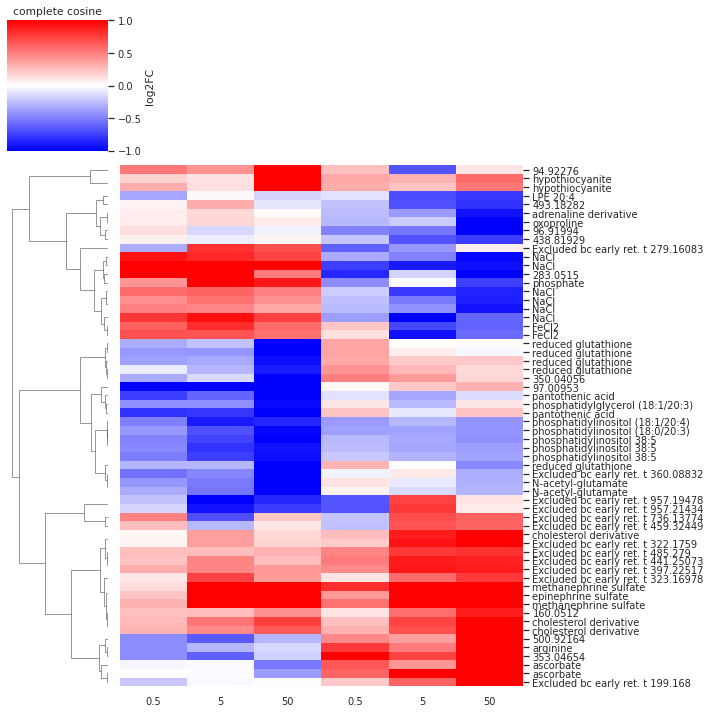

In [67]:
# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(annotated_df, cmap='bwr', col_cluster=False, vmin=-1, vmax=1, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['0.5', '5', '50', '0.5', '5', '50'], cbar_kws={'label':'log2FC'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# 11. clustering

In [68]:
df = annotated_df
df.head(20)

,0,1,2,3,4,5
pantothenic acid,-0.752395,-0.602723,-1.003354,-0.114541,-0.345187,-0.136880
cholesterol derivative,0.273868,0.545262,0.755746,0.243674,0.739899,1.188779
phosphatidylglycerol (18:1/20:3),-0.438642,-0.443705,-0.963922,0.096125,-0.267424,0.097321
epinephrine sulfate,0.233545,1.665070,3.504357,0.398993,2.274986,4.331534
adrenaline derivative,0.071142,0.153239,0.018522,-0.261877,-0.393728,-0.925120
Excluded bc early ret. t 736.13774,0.491006,-0.691675,0.225710,-0.226701,0.689901,0.617975
reduced glutathione,-0.294119,-0.285462,-1.311269,0.289119,-0.003676,-0.461455
500.92164,-0.450986,-0.642441,-0.281300,0.466293,0.377050,1.031436
Excluded bc early ret. t 957.19478,-0.241787,-1.003259,-0.845186,-0.666534,0.741554,0.103576
NaCl,0.924272,0.841890,0.737056,-0.335639,-0.484846,-0.983679


### 11.1. determine features annotated more than once: average and remove originals.

In [69]:
# detect duplications. create an average and remove
features = df.index.to_list()
multiplets_box = []
for element in features:
  if features.count(element) > 1:
    multiplets_box.append(element)
multiplets = list(set(multiplets_box))
print(len(multiplets), multiplets)

for element in multiplets:
    print(element, features.count(element))

10 ['hypothiocyanite', 'reduced glutathione', 'cholesterol derivative', 'NaCl', 'ascorbate', 'FeCl2', 'pantothenic acid', 'N-acetyl-glutamate', 'methanephrine sulfate', 'phosphatidylinositol 38:5']
hypothiocyanite 2
reduced glutathione 5
cholesterol derivative 3
NaCl 6
ascorbate 2
FeCl2 2
pantothenic acid 2
N-acetyl-glutamate 2
methanephrine sulfate 2
phosphatidylinositol 38:5 3


In [70]:
for multiplet in multiplets:
  new_name = '{}_average'.format(multiplet)
  print(new_name)
  average = pandas.DataFrame(df.loc[multiplet].mean(), columns=[new_name]).transpose()
  df = df.append(average)
  df.drop(multiplet, inplace=True)

hypothiocyanite_average
reduced glutathione_average
cholesterol derivative_average
NaCl_average
ascorbate_average
FeCl2_average
pantothenic acid_average
N-acetyl-glutamate_average
methanephrine sulfate_average
phosphatidylinositol 38:5_average


In [71]:
print(df.shape)
df.head(20)

(41, 6)


,0,1,2,3,4,5
phosphatidylglycerol (18:1/20:3),-0.438642,-0.443705,-0.963922,0.096125,-0.267424,0.097321
epinephrine sulfate,0.233545,1.665070,3.504357,0.398993,2.274986,4.331534
adrenaline derivative,0.071142,0.153239,0.018522,-0.261877,-0.393728,-0.925120
Excluded bc early ret. t 736.13774,0.491006,-0.691675,0.225710,-0.226701,0.689901,0.617975
500.92164,-0.450986,-0.642441,-0.281300,0.466293,0.377050,1.031436
Excluded bc early ret. t 957.19478,-0.241787,-1.003259,-0.845186,-0.666534,0.741554,0.103576
160.0512,0.248863,0.260211,0.430146,0.102832,0.567810,0.878511
oxoproline,0.071110,0.160425,0.082154,-0.275028,-0.195693,-1.067624
arginine,-0.440515,-0.284513,-0.157829,0.771529,0.515705,1.040314
LPE 20:4,-0.347208,0.030199,-0.167091,-0.115969,-0.698465,-0.769526


## 11.2. determine best partition

In [72]:
x = df.to_numpy()
k_range = range(3, 12+1)

In [73]:
pvx = []; pvy = []; all_labels = []
for k in k_range:

  kmeans_model = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
  labels = kmeans_model.labels_
  
  ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
  khi = sklearn.metrics.calinski_harabasz_score(x, labels)
  dbi = sklearn.metrics.davies_bouldin_score(x, labels)

  print(k, ss, khi, dbi)
  pvx.append(k)
  pvy.append(dbi)
  all_labels.append(labels)

3 0.6054097801726857 18.527605326119886 0.9234827499843058
4 0.5377327562340738 13.833954665688626 1.036592025736499
5 0.5614985653807225 11.656140501411276 1.0406021748155905
6 0.584158435513692 10.106652304482424 1.0204194921334262
7 0.6196627627462679 10.948943814344931 1.0761748210085682
8 0.5787722080049634 9.451190088442385 1.0330516958087106
9 0.5792747662558957 8.409251367753978 0.9641353250961873
10 0.6493058865314387 7.650003281786968 0.9267582000741037
11 0.6107430550901379 6.7841870263452595 0.9055923941696604
12 0.5824916848358731 6.285578054202765 0.8448059875089812


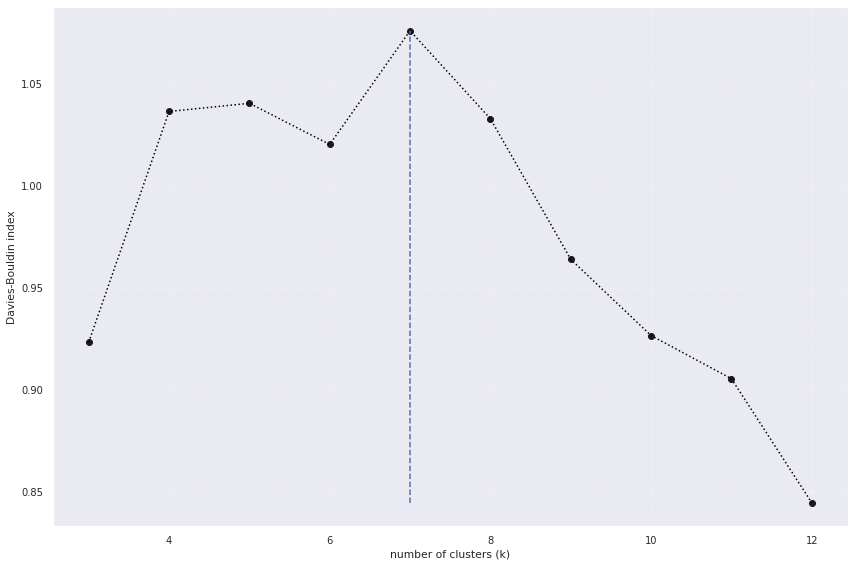

In [74]:
best_partition_index = 4
worst_partition_index = -1

matplotlib.pyplot.plot(pvx, pvy, 'ok')
matplotlib.pyplot.plot(pvx, pvy, ':', color='black')
matplotlib.pyplot.plot([pvx[best_partition_index], pvx[best_partition_index]], [pvy[worst_partition_index], pvy[best_partition_index]], ls='--')

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies-Bouldin index')
matplotlib.pyplot.tight_layout()
#matplotlib.pyplot.savefig('/content/drive/MyDrive/hi/research/huvec/results/untargeted/davies-bouldin_index.svg')

In [75]:
groupings = all_labels[best_partition_index]
groupings

array([0, 6, 5, 1, 4, 1, 6, 5, 4, 5, 4, 6, 6, 3, 0, 0, 0, 2, 5, 4, 1, 1,
       2, 5, 6, 0, 6, 5, 6, 2, 0, 3, 0, 6, 2, 4, 2, 0, 0, 6, 0])

In [76]:
color_options = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:gray', 'tab:olive']
k_colors = []
for i in range(len(df.index)):
  k_colors.append(color_options[groupings[i]])

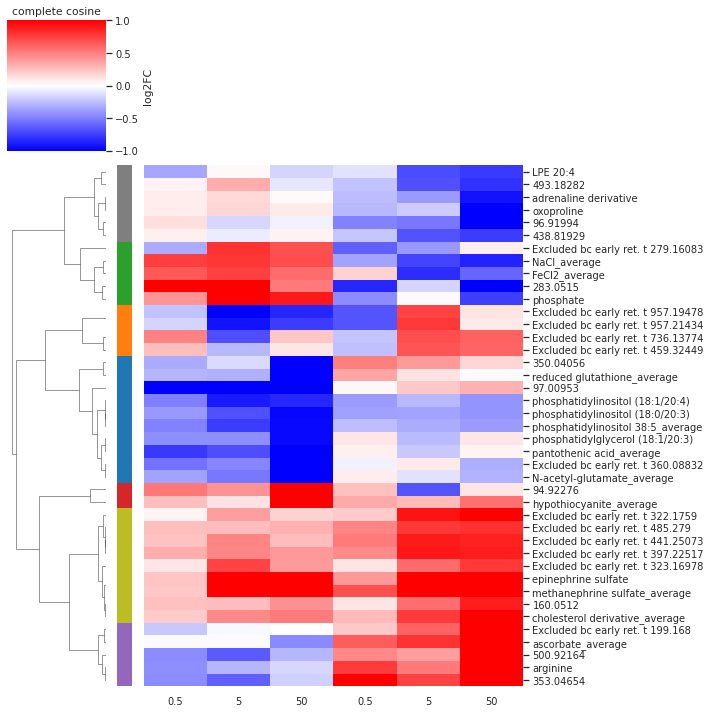

In [77]:
# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df, cmap='bwr', col_cluster=False, vmin=-1, vmax=1, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['0.5', '5', '50', '0.5', '5', '50'], cbar_kws={'label':'log2FC'}, row_colors=k_colors)

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('/home/adrian/scratch/heatmap.svg')